In [1]:
try:
    import tinygp
except ImportError:
    %pip install -q tinygp

try:
    import george
except ImportError:
    %pip install -q george

try:
    import celerite2
except ImportError:
    %pip install -q celerite2

In [2]:
import jax

(benchmarks)=

# Benchmarks

One of the `tinygp` design decisions was to provide a high-level API similar to the one provided by the [george](https://george.readthedocs.io) GP library.
This was partly because I (as the lead developer of `george`) wanted to ease users' transitions away from `george` to something more modern (like `tinygp`).
I also quite like the `george` API and don't think that there exist other similar tools.
The defining feature is `tinygp` does not include built-in implementations of inference algorithms.
Instead, it provides an expressive model-building interface that makes it easy to experiment with different kernels while still integrating with your favorite inference engine.

In this document, we compare the interface and computational performance of `tinygp` with [george](https://george.readthedocs.io) and [celerite2](https://celerite2.readthedocs.io) for constructing kernel models and evaluating the GP marginalized likelihood.
Since `tinygp` supports GPU-acceleration, we have executed this notebook on a machine with the following GPU:

In [3]:
!nvidia-smi --query-gpu=gpu_name --format=csv

/bin/bash: line 1: nvidia-smi: command not found


By default, the CPU versions of all of these libraries will use parallel linear algebra to take advantage of multiple CPU threads, however to make the benchmarks more replicable, we'll disable this parallelization for the remainder of this notebook.
We're also explicitly enabling `jax`'s support for double precision calculations, since the other libraries typically operate at double precision.

In [7]:
import os

os.environ["JAX_ENABLE_X64"] = "True"
os.environ["OMP_NUM_THREADS"] = "1"
# os.environ["XLA_FLAGS"] = (
#     os.environ.get("XLA_FLAGS", "")
#     + " --xla_cpu_multi_thread_eigen=false intra_op_parallelism_threads=1"
# )

In this benchmark, we'll compare the cost of computing the marginalized likelihood for a GP model using the following methods from other packages:

1. As a baseline, we'll run the default `george` solver, that uses `numpy` for linear algebra. This method scales as approximately $\mathcal{O}(N^3)$.
2. We also benchmark the HODLR solver implemented in `george`, which is an _approximate_ solver for black-box kernel models that scales asymptotically as $\mathcal{O}(N\log^2 N)$.
3. Finally, we run the `celerite2` implementation of the [celerite algorithm](https://arxiv.org/abs/1703.09710), which scales linearly with the size of the dataset, but it can only be used for datasets and models with restricted properties.

Then we compare these results to the runtime for the following implementations from `tinygp`:

1. The default solver, run on the CPU. This should have similar runtime and scaling as the `george` baseline from above.
2. The default solver, run on the GPU. This will have the same asymptotic scaling, but can be much faster than the CPU version for moderately large problems.
3. A scalable solver using "quasiseparable" structured matrices, much like the `celerite2` comparison above. This will have similar performance as `celerite2`, but suffer from the same restrictions on the kernel and dataset.

The syntax of these functions is quite similar, but there are a few differences.
Most notably, comparing the `george` and `tinygp` implementations, the units of the "metric" or "length scale" parameter in the kernel is different (length-squared in `george` and not squared in `tinygp`), and the `gp.compute` method no longer exists in `tinygp` since this would be less compatible with `jax`'s preference for pure functional programming.

In [8]:
from functools import partial

import celerite2
import george
import jax
import matplotlib.pyplot as plt
import numpy as np

import tinygp

jax.config.update("jax_enable_x64", True)

sigma = 1.5
rho = 2.5
jitter = 0.1

random = np.random.default_rng(49382)
x = np.sort(random.uniform(0, 10, 100_000))
y = np.sin(x) + jitter * random.normal(0, 1, len(x))


def george_loglike(x, y, **kwargs):
    kernel = sigma**2 * george.kernels.Matern32Kernel(rho**2)
    gp = george.GP(kernel, **kwargs)
    gp.compute(x, jitter)
    return gp.log_likelihood(y)


hodlr_loglike = partial(george_loglike, solver=george.solvers.HODLRSolver, tol=0.5)


def celerite_loglike(x, y):
    kernel = celerite2.terms.Matern32Term(sigma=sigma, rho=rho)
    gp = celerite2.GaussianProcess(kernel, x, diag=jitter**2)
    return gp.log_likelihood(y)


def tinygp_loglike(x, y):
    kernel = sigma**2 * tinygp.kernels.Matern32(rho)
    gp = tinygp.GaussianProcess(kernel, x, diag=jitter**2)
    return gp.log_probability(y)


tinygp_loglike_cpu = jax.jit(tinygp_loglike, backend="cpu")
# tinygp_loglike_gpu = jax.jit(tinygp_loglike, backend="gpu")


@partial(jax.jit, backend="cpu")
def quasisep_loglike(x, y):
    kernel = tinygp.kernels.quasisep.Matern32(sigma=sigma, scale=rho)
    gp = tinygp.GaussianProcess(kernel, x, diag=jitter**2, assume_sorted=True)
    return gp.log_probability(y)

Now we benchmark the computational cost of computing the log likelihood using each of these methods:

In [9]:
ns = [10, 20, 100, 200, 1_000, 2_000, 10_000, 20_000, len(x)]
george_time = []
hodlr_time = []
cpu_time = []
# gpu_time = []
quasisep_time = []
celerite_time = []
for n in ns:
    print(f"\nN = {n}:")

    args = x[:n], y[:n]
    gpu_args = jax.device_put(x[:n]), jax.device_put(y[:n])

    if n < 10_000:
        results = %timeit -o george_loglike(*args)
        george_time.append(results.average)

        tinygp_loglike_cpu(*args).block_until_ready()
        results = %timeit -o tinygp_loglike_cpu(*args).block_until_ready()
        cpu_time.append(results.average)

    if n <= 20_000:
        results = %timeit -o hodlr_loglike(*args)
        hodlr_time.append(results.average)

        # tinygp_loglike_gpu(*gpu_args).block_until_ready()
        # results = %timeit -o tinygp_loglike_gpu(*gpu_args).block_until_ready()
        # gpu_time.append(results.average)

    quasisep_loglike(*args).block_until_ready()
    results = %timeit -o quasisep_loglike(*args).block_until_ready()
    quasisep_time.append(results.average)

    results = %timeit -o celerite_loglike(*args)
    celerite_time.append(results.average)


N = 10:
88.2 μs ± 2.03 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
23.8 μs ± 1.88 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
68.2 μs ± 1.87 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
7.09 μs ± 121 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
27.5 μs ± 492 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)

N = 20:
91 μs ± 2.12 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
40.8 μs ± 3.13 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
72.2 μs ± 1.15 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
7.72 μs ± 247 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
29.1 μs ± 615 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)

N = 100:
162 μs ± 4.47 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
123 μs ± 3.38 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
141 μs ± 2.92 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
59.3

In the plot of this benchmark, you'll notice several features:

1. For very small datasets, the `tinygp` CPU implementations are significantly faster than any of the other implementations. This is because `jax.jit` removes a lot of the Python overhead that is encountered when chaining `numpy` functions.
2. For medium to large datasets, `tinygp` is generally faster than `george`, with the GPU version seeing a significant advantage.
3. The CPU implementations approach the expected asymptotic complexity of $\mathcal{O}(N^3)$ only for the largest values of $N$. This is probably caused by memory allocation overhead or other operations with better scaling than the Cholesky factorization.
4. The approximate "HODLR" solver from `george` outperforms the GPU-enabled `tinygp` exact solver, but only for very large datasets, and it's important to note that the HODLR method does not scale well to larger input dimensions. Any existing or future approximate solvers like this that are implemented in `jax` could be easily used in conjunction with `tinygp`, but such things have not yet been implemented.
5. The `celerite2` and `tinygp` structured kernel implementation have nearly identical performance for large systems, but the `tinygp` implementation is significantly faster for small systems (despite being implemented in high-level `jax`, whereas `celerite2` is mostly written in C++).

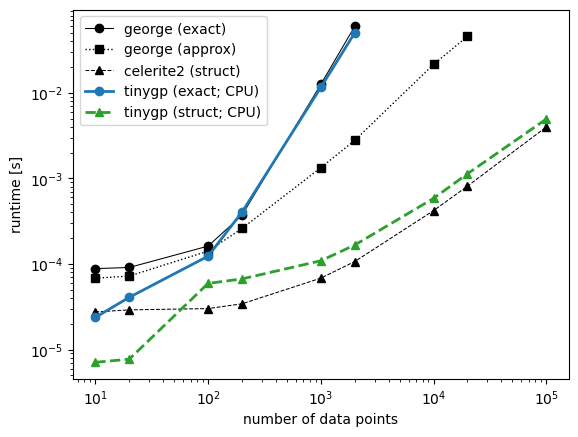

In [10]:
plt.loglog(
    ns[: len(george_time)],
    george_time,
    "o-",
    color="k",
    lw=0.75,
    label="george (exact)",
)
plt.loglog(
    ns[: len(hodlr_time)],
    hodlr_time,
    "s:",
    color="k",
    lw=1,
    label="george (approx)",
)
plt.loglog(ns, celerite_time, "^--", color="k", lw=0.75, label="celerite2 (struct)")

plt.loglog(
    ns[: len(cpu_time)],
    cpu_time,
    "o-",
    color="C0",
    lw=2,
    label="tinygp (exact; CPU)",
)

# plt.loglog(
#     ns[: len(gpu_time)],
#     gpu_time,
#     "o-",
#     color="C1",
#     lw=2,
#     label="tinygp (exact; GPU)",
# )
plt.loglog(ns, quasisep_time, "^--", color="C2", lw=2, label="tinygp (struct; CPU)")

plt.legend(fontsize=10)
plt.xlabel("number of data points")
plt.ylabel("runtime [s]");